In this notebook, we

* load up the saved .png files.
* read the image into a numpy array.
* partition the image into individual arrays (recall that each image is '012345689') representing each number.
* resize each digit image into 16*16

The features are the eigenvectors for each image array. Thus, if we have n images in our training set, this process produces an n * 16 feature matrix.

In [1]:
%pylab inline
pylab.style.use('ggplot')

import numpy as np
import pandas as pd
import cv2
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_dir = os.path.join(os.getcwd(), 'font_images')

if not os.path.isdir(image_dir) or len(os.listdir(image_dir)) == 0:
    print('no images found in {}'.format(image_dir))

First, we outline the processing for a single image.

In [3]:
img_mat = cv2.imread(os.path.join(image_dir, 'arial.png'))

# Convert to grayscale
gs = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)

In [4]:
gs.shape

(124, 911)

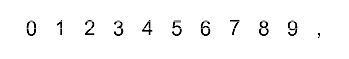

In [5]:
pylab.imshow(gs, cmap='gray')
pylab.tick_params(
        axis='both',          # changes apply to the x-axis and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', left='off', right='off', # don't display ticks
        labelbottom='off', labeltop='off', labelleft='off', labelright='off' # don't display ticklabels
) 

In [6]:
# Partition the columns into 10 equal parts
split_positions = np.linspace(0, gs.shape[1], num=12).astype(np.int)
split_positions = split_positions[1:-1]

# manual tweak by inspection
split_positions[0] += 10 

split_positions

array([ 92, 165, 248, 331, 414, 496, 579, 662, 745, 828])

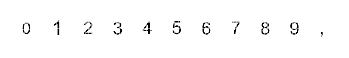

In [7]:
parts = np.array_split(gs, split_positions, axis=1)

fig, axes = pylab.subplots(1, len(parts))

for part, ax in zip(parts, axes):
    ax.imshow(part, cmap='gray')
    ax.tick_params(
        axis='both',          # changes apply to the x-axis and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', left='off', right='off', # don't display ticks
        labelbottom='off', labeltop='off', labelleft='off', labelright='off' # don't display ticklabels
)

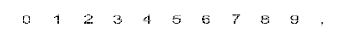

In [8]:
fig, axes = pylab.subplots(1, len(parts))

binarized = []

for ax, p in zip(axes, parts):
    resized = cv2.resize(p, (32, 32))
    _, bin_img = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)
    
    binarized.append(bin_img)
    
    ax.imshow(bin_img, cmap='gray')
    ax.tick_params(
        axis='both',          # changes apply to the x-axis and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', left='off', right='off', # don't display ticks
        labelbottom='off', labeltop='off', labelleft='off', labelright='off' # don't display ticklabels
    )
    

Now we're ready to build image features. Let's take one of the images and work out the feature extraction process.

# Statistical Features

## Fraction of On Pixels

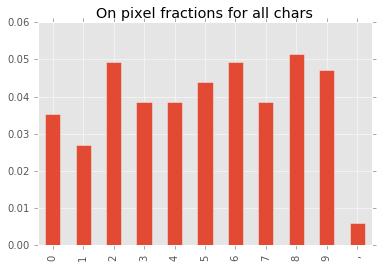

In [9]:
def calc_on_pixel_fraction(part_img):
    # Note that on pixel == 0, off pixel == 255
    _, counts = np.unique(part_img, return_counts=True)
    return counts[0] / counts[1]

on_pixel_fractions = [calc_on_pixel_fraction(p) for p in binarized]
on_pixel_fractions = pd.Series(on_pixel_fractions, index=list('0123456789,'))
on_pixel_fractions.plot(kind='bar', title='On pixel fractions for all chars')

## Mean x, y Positions of All On Pixels

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D06176F710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001D0617C0B00>], dtype=object)

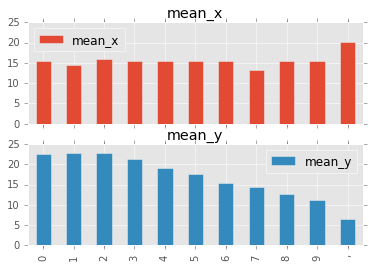

In [10]:
# Again, note that on pixel == 0, off pixel == 255
def calc_f_on_pixel_pos(part_img, f, axis=0):
    assert axis in (0, 1)
    on_x, on_y = np.where(part_img==0)
    on_dim = on_x if axis == 0 else on_y    
    return f(on_dim)

m_x = [calc_f_on_pixel_pos(p, np.mean, axis=0) for p in binarized]
m_y = [calc_f_on_pixel_pos(p, np.mean, axis=1) for p in binarized]

mean_on_pixel_xy = pd.DataFrame(np.column_stack([m_x, m_y]), 
                                index=list('0123456789,'), 
                                columns=['mean_x', 'mean_y'])

mean_on_pixel_xy.plot(kind='bar', subplots=True)

## Variance of x-y Positions of All on Pixels

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D061830C50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001D06192DDD8>], dtype=object)

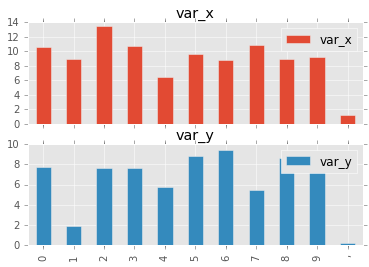

In [11]:
v_x = [calc_f_on_pixel_pos(p, np.var, axis=0) for p in binarized]
v_y = [calc_f_on_pixel_pos(p, np.var, axis=1) for p in binarized]

var_on_pixel_xy = pd.DataFrame(np.column_stack([v_x, v_y]), 
                                index=list('0123456789,'), 
                                columns=['var_x', 'var_y'])

var_on_pixel_xy.plot(kind='bar', subplots=True)

## Correlation of x-y positions of All Pixels

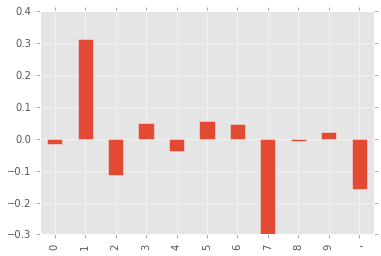

In [12]:
def calc_on_pixel_x_y_corr(part_img):
    coef = np.corrcoef(np.where(part_img == 0))
    return coef[1, 0]

x_y_corrs = [calc_on_pixel_x_y_corr(p) for p in binarized]
x_y_corrs = pd.Series(x_y_corrs, index=list('0123456789,'))

x_y_corrs.plot(kind='bar')

**Note**: I decided to not use this feature after adding the moment based features.

## Moment Based Features

Moment calculation in OpenCV is described here:

http://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html

In [13]:
def calc_moments(part_img):
    moments = cv2.moments(part_img, binaryImage=True)
    return moments

m_list = [calc_moments(p) for p in binarized]

m_df = pd.DataFrame.from_records(m_list)

chars = ('zero', 'one', 'two', 'three', 'four', 
         'five', 'six', 'seven', 'eight', 'nine', 'comma')

m_df.index = chars

In [14]:
m_df.head()

,m00,m01,m02,m03,m10,m11,m12,m20,m21,m30,...,mu20,mu21,mu30,nu02,nu03,nu11,nu12,nu20,nu21,nu30
zero,989.0,15335.0,324701.0,7728947.0,15086.0,233962.0,4973130.0,315390.0,4891614.0,7457846.0,...,85271.298281,-60.956806,45531.387526,0.088868,-0.000043,0.000046,0.000611,0.087179,-0.000002,0.001480
one,997.0,15479.0,327351.0,7778453.0,15254.0,236986.0,5028816.0,319116.0,4958184.0,7545362.0,...,85731.329990,-1136.800230,39557.707789,0.087555,-0.000199,0.000160,0.000492,0.086248,-0.000036,0.001260
two,976.0,15109.0,320537.0,7649701.0,14783.0,228761.0,4878331.0,308241.0,4770291.0,7287251.0,...,84330.048156,1213.282613,63860.726667,0.090955,0.000171,-0.000092,0.000875,0.088528,0.000041,0.002146
three,986.0,15283.0,323773.0,7712023.0,15066.0,233506.0,4963800.0,315928.0,4896124.0,7491924.0,...,85720.742394,-240.482759,44957.815617,0.089371,0.000002,-0.000017,0.000560,0.088172,-0.000008,0.001473
four,986.0,15288.0,324094.0,7723506.0,15150.0,234929.0,4991217.0,319376.0,4952401.0,7599804.0,...,86594.559838,-381.630424,31485.984703,0.089542,-0.000036,0.000028,0.000348,0.089071,-0.000013,0.001031


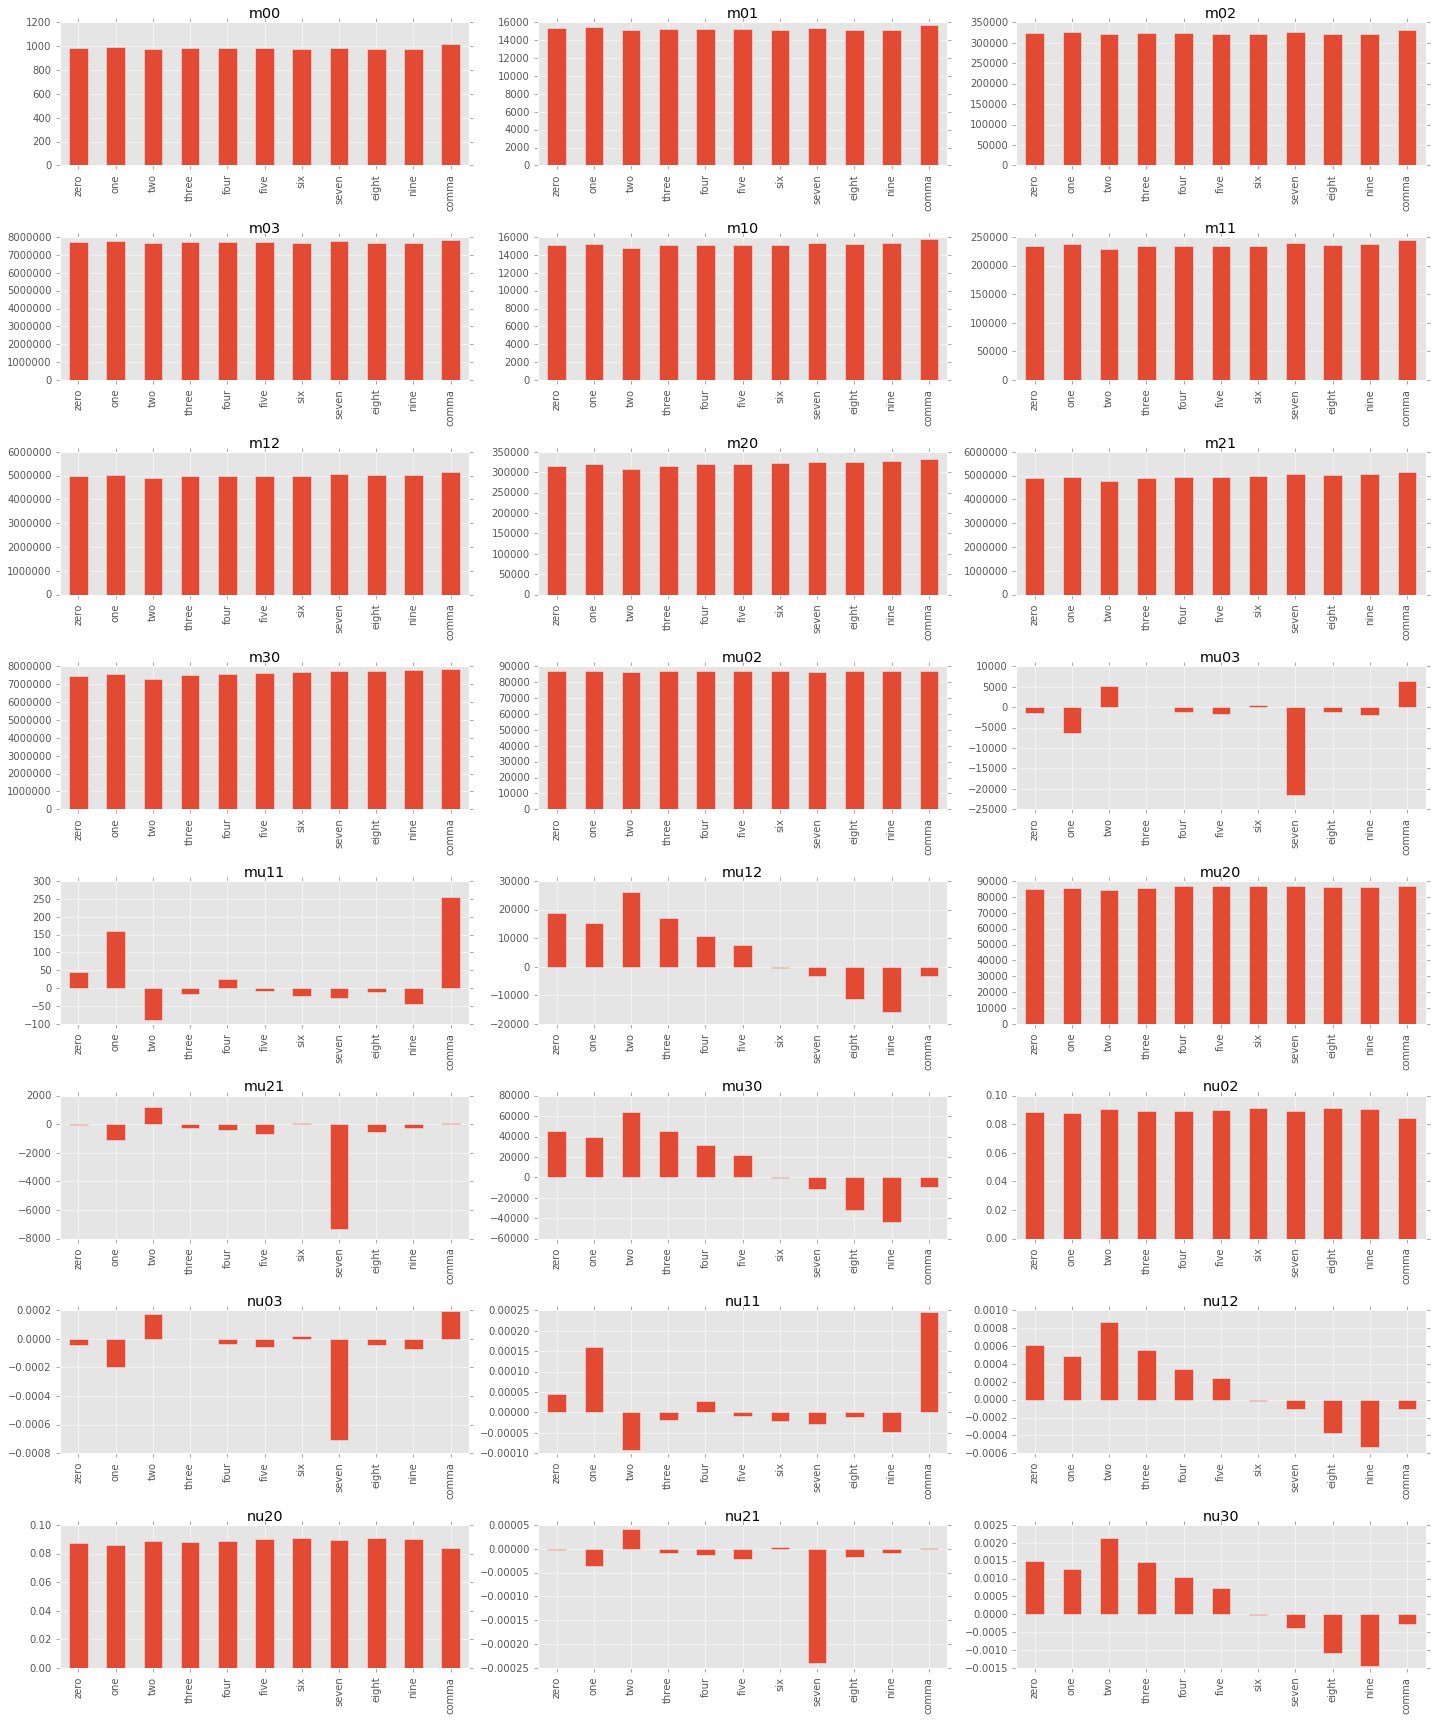

In [15]:
figure, axes = pylab.subplots(8, 3, figsize=(20, 24))

moment_cols = m_df.columns.values.reshape(8, 3)

for i, row in enumerate(moment_cols):
    for j, col in enumerate(row):    
        m_df.loc[:, col].plot(kind='bar', title=col, ax=axes[i][j])

pylab.tight_layout()

So, among all the moments, we choose the normalized moments: nu03, nu11 ('en-eu-one-one'), and nu12. All the other features are have similar shapes across the character classes.

## DCT Based Features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0634DA0B8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001D064D156D8>], dtype=object)

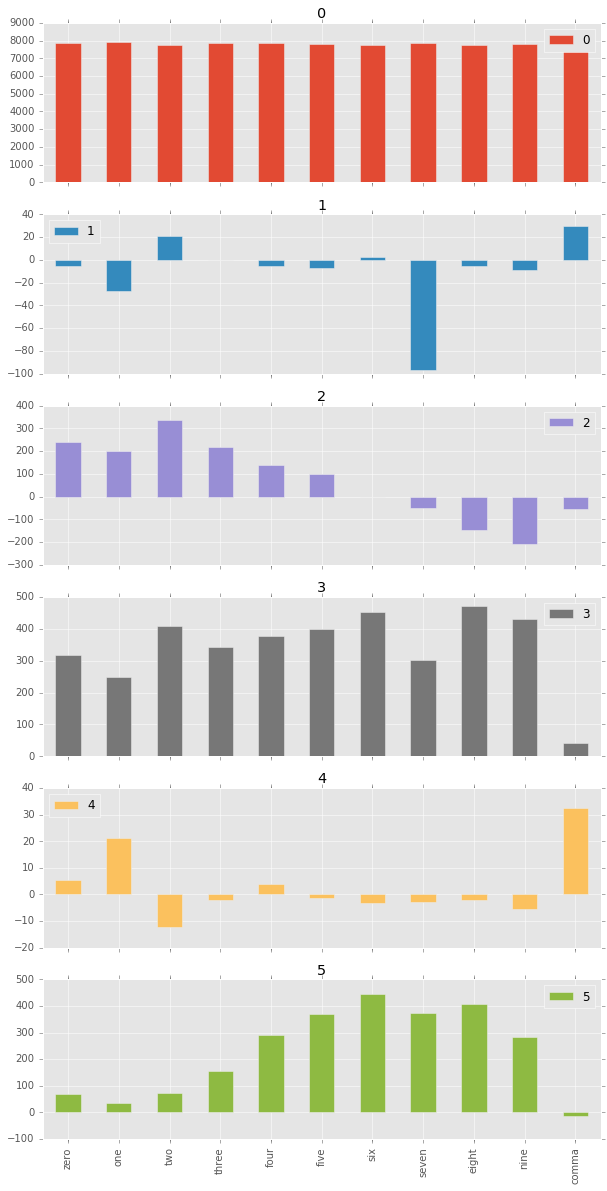

In [26]:
from scipy.fftpack import dct

def calc_dct2d_zigzagged_coeffs(part_img, n_diags=3):
    dct_result = dct(dct(part_img, norm='ortho').T, norm='ortho')
    # To make a feature vector out of the DCT results by taking the elements 
    # of dct_result in a zigzagged fashion.
    # We can access these efficiently
    # by taking the mirror image and accessing the diagonals.
    mirrored = np.fliplr(dct_result)
    
    idx_first = mirrored.shape[0] - 1
    idx_last = idx_first - n_diags
            
    zigzagged_coeffs = np.concatenate([np.diag(mirrored, k) 
        for k in range(idx_first, idx_last, -1)])
    
    return zigzagged_coeffs

diag_var_dct = [calc_dct2d_zigzagged_coeffs(p, n_diags=3) for p in binarized]

dct_df = pd.DataFrame.from_records(diag_var_dct, index=chars)
dct_df.plot(kind='bar', subplots=True, figsize=(10, 20))

# Putting it Together

In [17]:
def partition_image(img_file, n_chars, size=32, threshold=127):
    """
    * Read the RGB image `img_file` 
    * Convert to grayscale
    * Split into one subarray per character
    * Resize to `size * size`
    * Binarize with threshold `threshold`
    
    Return a list of subarrays for each character.
    """
    assert os.path.isfile(img_file)
    
    img_mat = cv2.imread(img_file)    
    gs = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    split_positions = np.linspace(0, gs.shape[1], num=n_chars+1).astype(np.int)
    split_positions = split_positions[1:-1]
    
    # manual tweak by inspection
    split_positions[0] += 10 
    
    parts = np.array_split(gs, split_positions, axis=1)
    
    resized_images = []
    
    for p in parts:
        p_new = cv2.resize(p, (size, size))
        _, bin_img = cv2.threshold(p_new, threshold, 255, cv2.THRESH_BINARY)
        resized_images.append(bin_img)
        
    return resized_images

In [18]:
from functools import partial

def calc_on_pixel_fraction(part_img):
    _, counts = np.unique(part_img, return_counts=True)
    return counts[0] /counts[1]

def calc_f_on_pixel_pos(part_img, f, axis=0):
    assert axis in (0, 1)
    on_x, on_y = np.where(part_img==0)
    on_dim = on_x if axis == 0 else on_y    
    return f(on_dim)

def calc_on_pixel_x_y_corr(part_img):
    coef = np.corrcoef(np.where(part_img == 0))
    return coef[0, 1]

def calc_moments(part_img, moments_to_keep={'nu03', 'nu11', 'nu12'}):
    moments = cv2.moments(part_img, binaryImage=True)
    return {k: v for k, v in moments.items() if k in moments_to_keep}

In [27]:
from scipy.fftpack import dct

def calc_dct2d_zigzagged_coeffs(part_img, n_diags=3):
    """Return a 1D numpy array with the zigzagged 2D DCT coefficients."""
    
    dct_result = dct(dct(part_img, norm='ortho').T, norm='ortho')    
    mirrored = np.fliplr(dct_result)
    
    idx_first = mirrored.shape[0] - 1
    idx_last = idx_first - n_diags
            
    zigzagged_coeffs = np.concatenate([np.diag(mirrored, k) 
        for k in range(idx_first, idx_last, -1)])
    
    return zigzagged_coeffs
    
# dictionary of functions 
feature_calc = {
    'on_pixel_frac': calc_on_pixel_fraction,
    # 'on_pixel_x_mean': partial(calc_f_on_pixel_pos, f=np.mean, axis=0),
    # 'on_pixel_y_mean': partial(calc_f_on_pixel_pos, f=np.mean, axis=1),
    'on_pixel_x_var': partial(calc_f_on_pixel_pos, f=np.var, axis=0),
    'on_pixel_y_var': partial(calc_f_on_pixel_pos, f=np.var, axis=1),
    # 'on_pixel_x_y_corr': calc_on_pixel_x_y_corr,
}

def extract_features(img_file, chars):
    """
    Extract_features for a combined image. Returns a DataFrame with 1 row per character.
    """
    char_images = partition_image(img_file, len(chars))
    font_name = os.path.basename(img_file).split('.')[0]
    
    features = []
    
    for char_img in char_images:
        feature_vals = {fname: fgen(char_img) for fname, fgen in feature_calc.items()}
        
        # Calculate the moment feature values separately and  update feature_vals.
        moment_features = calc_moments(char_img)
        feature_vals.update(moment_features)        
        features.append(feature_vals)
        
    features = pd.DataFrame.from_records(features, index=chars)
    features.index.name = 'char_name'
    features['font_name'] = font_name
    
    # Include the DCT features
    dct_features = [calc_dct2d_zigzagged_coeffs(p) for p in char_images]
    dct_features = pd.DataFrame.from_records(diag_var_dct, index=chars)
    dct_features.columns = ['dct_{}'.format(c) for c in dct_features.columns]
    
    # Combine DCT and other features
    all_features = pd.concat([features, dct_features], axis=1)
    
    return all_features

In [28]:
from IPython.display import display
from ipywidgets import FloatProgress

font_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
prog = FloatProgress(min=1, max=len(font_files), description='Extracting features...')
display(prog)

all_features = []

chars = ('zero', 'one', 'two', 'three', 'four', 
         'five', 'six', 'seven', 'eight', 'nine', 'comma')

for font_file in font_files:
    feature_df = extract_features(font_file, chars)
    all_features.append(feature_df)    
    prog.value += 1
    
prog.bar_style = 'success'
    
all_features = pd.concat(all_features, axis=0)

In [29]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, zero to comma
Data columns (total 13 columns):
nu03              1496 non-null float64
nu11              1496 non-null float64
nu12              1496 non-null float64
on_pixel_frac     1496 non-null float64
on_pixel_x_var    1496 non-null float64
on_pixel_y_var    1496 non-null float64
font_name         1496 non-null object
dct_0             1496 non-null float64
dct_1             1496 non-null float64
dct_2             1496 non-null float64
dct_3             1496 non-null float64
dct_4             1496 non-null float64
dct_5             1496 non-null float64
dtypes: float64(12), object(1)
memory usage: 163.6+ KB


In [30]:
num_values = all_features.drop('font_name', axis=1)
np.isfinite(num_values).sum(axis=0)

nu03              1496
nu11              1496
nu12              1496
on_pixel_frac     1496
on_pixel_x_var    1496
on_pixel_y_var    1496
dct_0             1496
dct_1             1496
dct_2             1496
dct_3             1496
dct_4             1496
dct_5             1496
dtype: int64

In [31]:
# This is only necessary if on_pixel_x_y_corr is included.

if 'on_pixel_x_y_corr' in all_features.keys():
    invalid_corr = ~np.isfinite(all_features['on_pixel_x_y_corr'])
    all_features.loc[invalid_corr, 'on_pixel_x_y_corr']

    comma_mean = all_features.loc['comma', 'on_pixel_x_y_corr'].mean()
    four_mean = all_features.loc['four', 'on_pixel_x_y_corr'].mean()

    invalid_comma_idx = (all_features.index == 'comma') & invalid_corr
    all_features.loc[invalid_comma_idx, 'on_pixel_x_y_corr'] = comma_mean

    invalid_four_idx = (all_features.index == 'four') & invalid_corr
    all_features.loc[invalid_four_idx, 'on_pixel_x_y_corr'] = four_mean

In [32]:
all_features.to_csv('char_features.csv')